In [1]:
# running ViViT with 3D MNIST dataset 

# Code source of implementation of ViViT: https://github.com/rishikksh20/ViViT-pytorch


# Only model 2 from ViViT: A Video Transformer is implemented 

In [1]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from module import Attention, PreNorm, FeedForward
from scipy import ndimage
import numpy as np
import random

from MNIST_3D_data import MNIST_3D_Growing, MNIST_3D_Random_Rotation, MNIST_3D_Gaussian_Noise, scipy_clipped_zoom_3d
from vivit import ViViT 

In [2]:
# set seed
def seed_all(seed=10):


    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all()

[ Using Seed :  10  ]


### Loading 3DMnist data

In [3]:
from torchvision import transforms, utils
transforms = transforms.Compose([
    MNIST_3D_Random_Rotation(max_angle = 15),
    MNIST_3D_Gaussian_Noise(mean = 0, var = 0.000001)
])

In [4]:
config = {
    'num_train_data': 1000,
    'num_test_data' : 200,
    'class_names' : ['non', 
                   'slow_g',
                   'steady_g',
                   'fast_g',
                   'slow_s',
                   'steady_s',
                   'fast_s'],
    'class_growth_rates' : {'non' : 1,
                          'slow_g' :1.1,
                          'steady_g':1.2,
                          'fast_g': 1.3,
                          'slow_s': 0.9,
                          'steady_s': 0.8,
                          'fast_s': 0.75}

}

In [5]:
save_path = './dataset/3D_MNIST_vanilla.npz'
training_data = MNIST_3D_Growing(save_path, scipy_clipped_zoom_3d, 
                                 config['num_train_data'],  
                                 train = True,
                                 transforms = transforms,
                                 class_names = config['class_names'],  
                                 class_growth_factors = config['class_growth_rates']
                                 
                                )
testing_data = MNIST_3D_Growing(save_path, scipy_clipped_zoom_3d, 
                                 config['num_test_data'],
                                 train = False,
                                transforms = transforms,
                                class_names = config['class_names'],  
                                 class_growth_factors = config['class_growth_rates']
                                
                                )

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

training_generator = torch.utils.data.DataLoader(training_data, batch_size=16,worker_init_fn=seed_worker,
        generator=g)
testing_generator = torch.utils.data.DataLoader(testing_data, batch_size=16,worker_init_fn=seed_worker,
        generator=g)


In [7]:
# train_features, train_labels = next(iter(training_generator))
# train_features.shape
# batch size = 16, time steps = 3, 28 x 28 x 28 image

### Initializing model

In [21]:
# documenting the ViViT class from https://github.com/rishikksh20/ViViT-pytorch

# def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.,
#                 emb_dropout = 0., scale_dim = 4, ):
        
# image size: height = width of image 
# patch size: size of the little patches where an image will be divided into 
# num classes
# num frames 
# dim: dimension of the input zl (rasterized image patch) 
# depth: number of attention layers
# heads: number of heads in an attention layer 
# pool: pool type must be either cls (cls token) or mean (mean pooling)
# in_channels: number of channels of input
# dim_head: dimensions of the heads

# vivit_input = {
#     'image_size': 28,
#     'patch_size': 14, 
#     'num_classes': len(config["class_names"]),
#     'num_frames': 3, 
#     'in_channels': 1
# }

# model = ViViT(image_size=vivit_input["image_size"], 
#               patch_size=vivit_input["patch_size"], 
#               num_classes=vivit_input["num_classes"], 
#               num_frames=vivit_input["num_frames"], 
#               in_channels=vivit_input["in_channels"])




In [7]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda:0')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print('cpu')
    device = torch.device('cpu')

cpu


In [8]:
# source: https://github.com/bdrad/project-conv-meleon/blob/3DMNIST/ConvLSTM_3D_training_loop.ipynb

def validate(model, data_loader):
        model.eval()
        correct = 0
        with torch.no_grad():
            for features, labels in data_loader:
                features = features.to(torch.float)
                
                # reshaping input into the model to match the dimensions
                # num frame x channels x height x width 
                features = torch.unsqueeze(torch.squeeze(features), 2)
                
                labels = labels.to(torch.long)
                features = features.to(device)
                labels = labels.to(device)
                outputs = torch.argmax(model(features), dim=1)
                correct += int(torch.sum(outputs==labels))
        print(f'Validation Accuracy: {correct/(len(data_loader) * data_loader.batch_size) * 100:.3f}%')
        return correct/(len(data_loader) * data_loader.batch_size) * 100

def save_model(model, savepath):
    torch.save(model.state_dict(), savepath)

### Training loop

In [10]:


model_log = {
    "validation_accuracy": [], 
    "training_loss": []
}


In [15]:
import time

def training_loop(iteration, training_dataloader, testing_dataloader, vivit_input):
    
    
    
    model = ViViT(image_size=vivit_input["image_size"], 
                  patch_size=vivit_input["patch_size"], 
                  num_classes=vivit_input["num_classes"], 
                  num_frames=vivit_input["num_frames"], 
                  in_channels=vivit_input["in_channels"])
    
    #hyperparameters
    epochs=10
    learning_rate = 1e-4
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    
    validation_acc = []
    training_loss = []
    
    for epoch in range(epochs):

        start = time.time()

        model.train()
        current_train_loss = 0
        length = 0
        for x, y in training_dataloader:
            optimizer.zero_grad()

            # reshape data to fit into model 
            # x should have the dimensions batch x num frame x channels x height x width x depth
            x = torch.squeeze(x)
            x = torch.unsqueeze(x, 2)

            x = x.to(device).type(torch.float32)
            y = y.to(device).long()

            output = model(x)
            loss = criterion(output, y)
            current_train_loss += float(loss.item())
            length += x.shape[0]
            # ===================backward====================
            loss.backward()
            optimizer.step()
        # ===================log========================
        current_train_loss = current_train_loss / length

        print("Epoch {} of iteration {} training loss: {}".format(epoch+1, iteration, current_train_loss))
        val_acc = validate(model, testing_dataloader)
        validation_acc.append(val_acc)
        training_loss.append(current_train_loss)

        end = time.time()
        print("time elapsed: {} seconds".format(end-start))
        
    return validation_acc, training_loss

In [17]:
vivit_input = {
'image_size': 28,
'patch_size': 14, 
'num_classes': len(config["class_names"]),
'num_frames': 3, 
'in_channels': 1
}

iteration_num = 5

for i in range(iteration_num):
        
    validation_acc, training_loss = training_loop(iteration=i, training_dataloader=training_generator, 
                                                  testing_dataloader=testing_generator, vivit_input=vivit_input)

    
    model_log['validation_accuracy'].append(validation_acc)
    model_log['training_loss'].append(training_loss)

Epoch 1 of iteration 0 training loss: 0.10304774498939515
Validation Accuracy: 48.558%
time elapsed: 12.542895078659058 seconds
Epoch 2 of iteration 0 training loss: 0.052501707196235654
Validation Accuracy: 64.423%
time elapsed: 12.778615951538086 seconds
Epoch 3 of iteration 0 training loss: 0.036451172679662705
Validation Accuracy: 70.192%
time elapsed: 12.811910152435303 seconds
Epoch 4 of iteration 0 training loss: 0.02325352492928505
Validation Accuracy: 69.231%
time elapsed: 12.56761908531189 seconds
Epoch 5 of iteration 0 training loss: 0.01455513820797205
Validation Accuracy: 75.000%
time elapsed: 12.603848218917847 seconds
Epoch 6 of iteration 0 training loss: 0.010681383408606053
Validation Accuracy: 75.000%
time elapsed: 12.638353109359741 seconds
Epoch 7 of iteration 0 training loss: 0.007789501659572124
Validation Accuracy: 64.904%
time elapsed: 12.651286840438843 seconds
Epoch 8 of iteration 0 training loss: 0.011016113149002195
Validation Accuracy: 69.712%
time elapsed:

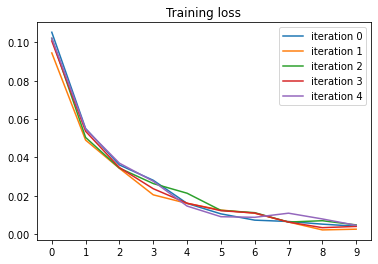

In [26]:
import matplotlib.pyplot as plt 

plt.title("Training loss")
plt.xticks(np.arange(epochs))
for i in range(iteration_num):
    plt.plot(model_log['training_loss'][i], label="iteration {}".format(i))
plt.legend();


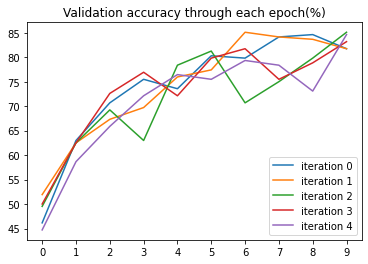

In [25]:
import matplotlib.pyplot as plt 

plt.title("Validation accuracy through each epoch(%)")
plt.xticks(np.arange(epochs))
for i in range(iteration_num):
    plt.plot(model_log['validation_accuracy'][i], label="iteration {}".format(i))
plt.legend();


In [28]:
# save results
np.savez("vivit_toy_dataset_results_5_iter.npz", 
             validation_accuracy=model_log['validation_accuracy'], 
            training_loss=model_log['training_loss'])
    